# Check GPU

In [1]:
import torch

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

GPU Available: False


# Load cleaned annotated SWiPE dataset

index to del: ID: 1898

In [131]:
from datasets import load_from_disk

swipe_clean_dataset = load_from_disk("../data/swipe_clean_annotated")
swipe_clean_dataset

DatasetDict({
    train: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 3861
    })
    validation: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 479
    })
    test_id: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 483
    })
    test_ood: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 368
    })
})

# Inspect elaborative simplification samples

## Count number of elaborations in the dataset

In [5]:
from collections import defaultdict

def count_specific_annotations(dataset, specific_categories):
    category_count = defaultdict(int)
    for example in dataset:
        if example['annotations'] is not None:
            if example['annotations']: 
                for annotation in example['annotations']:
                    if annotation['category'] in specific_categories:
                        category_count[annotation['category']] += 1
    return category_count

# eleboration categories
specific_categories = ['semantic_elaboration_background', 'semantic_elaboration_example', 'semantic_elaboration_generic']

# Count for each dataset
train_specific_counts = count_specific_annotations(swipe_clean_dataset['train'], specific_categories)
val_specific_counts = count_specific_annotations(swipe_clean_dataset['validation'], specific_categories)
test_id_specific_counts = count_specific_annotations(swipe_clean_dataset['test_id'], specific_categories)
test_ood_specific_counts = count_specific_annotations(swipe_clean_dataset['test_ood'], specific_categories)

In [6]:
print('semantic_elaboration_generic')
print("Train :", train_specific_counts['semantic_elaboration_generic'])
print("Validation:", val_specific_counts['semantic_elaboration_generic'])
print("Test ID:", test_id_specific_counts['semantic_elaboration_generic'])
print("Test OOD:", test_ood_specific_counts['semantic_elaboration_generic'])

semantic_elaboration_generic
Train : 2260
Validation: 270
Test ID: 295
Test OOD: 356


In [7]:
print('semantic_elaboration_background')
print("Train :", train_specific_counts['semantic_elaboration_background'])
print("Validation:", val_specific_counts['semantic_elaboration_background'])
print("Test ID:", test_id_specific_counts['semantic_elaboration_background'])
print("Test OOD:", test_ood_specific_counts['semantic_elaboration_background'])

semantic_elaboration_background
Train : 604
Validation: 76
Test ID: 81
Test OOD: 39


In [8]:
print('semantic_elaboration_example')
print("Train :", train_specific_counts['semantic_elaboration_example'])
print("Validation:", val_specific_counts['semantic_elaboration_example'])
print("Test ID:", test_id_specific_counts['semantic_elaboration_example'])
print("Test OOD:", test_ood_specific_counts['semantic_elaboration_example'])

semantic_elaboration_example
Train : 98
Validation: 7
Test ID: 20
Test OOD: 13


In [29]:
swipe_clean_dataset['train'][1]['annotations']

[{'category': 'lexical_generic', 'gi': 0, 'opis': [1, 2]},
 {'category': 'lexical_generic', 'gi': 1, 'opis': [4, 5, 6]},
 {'category': 'syntactic_deletion', 'gi': 2, 'opis': [8]},
 {'category': 'syntactic_sentence_fusion', 'gi': 3, 'opis': [12, 11, 10]},
 {'category': 'lexical_generic', 'gi': 4, 'opis': [14, 15]},
 {'category': 'syntactic_deletion', 'gi': 5, 'opis': [17]},
 {'category': 'nonsim_format', 'gi': None, 'opis': [19, 20]}]

## Save each elaboration category in dataframe

In [3]:
import pandas as pd
from tqdm.notebook import tqdm

def get_texts_with_specific_annotations(dataset_dict, specific_categories):
    # store texts per category
    category_data = {category: {'raw_texts': [], 'references': [], 'annotations': [], 'ids': [], 'splits': []} for category in specific_categories}
    for split_name, dataset in dataset_dict.items():
        for idx, example in tqdm(enumerate(dataset), total=len(dataset)):
            if example['annotations']: 
                for annotation in example['annotations']:
                    if annotation['category'] in specific_categories:
                        
                        category_data[annotation['category']]['raw_texts'].append(example['r_content'])
                        category_data[annotation['category']]['references'].append(example['s_content'])
                        category_data[annotation['category']]['annotations'].append(annotation['category'])
                        category_data[annotation['category']]['ids'].append(idx)
                        category_data[annotation['category']]['splits'].append(split_name)

    # turn each category's data into a separate dfs
    dataframes = {}
    for category, data in category_data.items():
        df = pd.DataFrame({
            'id': data['ids'],
            'split': data['splits'],              
            'text': data['raw_texts'],
            'reference': data['references'],
            'annotation': data['annotations']
        })
        dataframes[category] = df

    return dataframes

# elaboration categories
specific_categories = ['semantic_elaboration_background', 'semantic_elaboration_example', 'semantic_elaboration_generic']

In [4]:
dataframes = get_texts_with_specific_annotations(swipe_clean_dataset, specific_categories)

  0%|          | 0/3861 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

In [5]:
background_df = dataframes['semantic_elaboration_background']
example_df = dataframes['semantic_elaboration_example']
generic_df = dataframes['semantic_elaboration_generic']

In [6]:
print('Semantic Elaboration background: ', len(background_df))
print('Semantic Elaboration example: ', len(example_df))
print('Semantic Elaboration generic: ', len(generic_df))

Semantic Elaboration background:  800
Semantic Elaboration example:  138
Semantic Elaboration generic:  3181


In [7]:
background_df.to_csv('../data/elaborations/background.csv', index=False)
example_df.to_csv('../data/elaborations/example.csv', index=False)
generic_df.to_csv('../data/elaborations/generic.csv', index=False)

# Investigate main features of elaboration texts

In [132]:
import sys
import os
utils_path = "../utils/"
sys.path.append(utils_path)

## Text highlights

In [133]:
from IPython.core.display import HTML
import utils_diff

def highlight_operations(text, reference, annotation, edits, operations):
    # create a set to store the indices of elaboration operations
    elaboration_op_indices = set()
    
    # iterate through edits to collect 'elaboration' categories
    for edit in edits:
        if edit['category'] == annotation:  # check if the category is a desired elaboration type
            elaboration_op_indices.update(edit['opis'])  # add indices of the corresponding dict in operations list
    
    # highlight elaborations by iterating through the operations
    highlighted_text = ""
    
    for idx, operation in enumerate(operations):
        if operation['type'] == 'insert':
            if idx in elaboration_op_indices:  # if the operation index is in the elaboration set
                # only highlight insertions (elaborations)
                highlighted_text += f'<span style="background-color: #90EE90">{operation["insert"]}</span> '
            else:
                # other insertions type
                highlighted_text += f'<span style="background-color: #FFA500">{operation["insert"]}</span> '
        # include the text that was unchanged
        elif operation['type'] == 'equal':
            highlighted_text += f'{operation["text"]} '
        # include deleted text or replaced text
        elif operation['type'] == 'delete':
            highlighted_text += f'<span style="text-decoration: line-through; color: red;">{operation["delete"]}</span> '
        #else:
            #highlighted_text += f'{operation.get("text", "")} '
    
    # display the highlighted text as HTML
    display(HTML(highlighted_text))

In [134]:
import utils_diff

def get_elab_operation_list(text, ref, category, edits):
    # get the full list of operations
    operations = utils_diff.get_edit_operations(text, ref, split_replace=True, split_sentences=True)
    
    # set to store indices of elaboration-related operations
    elab_op_indices = set()
    
    # collect the operation indices for the specified category
    for edit in edits:
        if edit['category'] == category:  # check if the edit category matches the provided category
            elab_op_indices.update(edit['opis'])  # add indices of operations for this category
    
    # filter the operations to include only those in elab_op_indices
    elab_operations = [operations[idx] for idx in elab_op_indices]
    
    return elab_operations

In [135]:
def get_elab_edits(edits, category):
    # filter and return edits that match the specified category
    elab_edits = [edit for edit in edits if edit['category'] == category]
    
    return elab_edits

## Get samples

In [136]:
import utils_diff 

def get_random_samples(df, num_samples=10):

    samples = df.sample(n=num_samples, random_state=42)
    for _, sample in samples.iterrows():
        
        idx = sample['id']
        ds_split = sample['split']
        category = sample['annotation']
        record = swipe_clean_dataset[ds_split][idx]
        text = sample['text']
        ref = sample['reference']
        edits = record['annotations']
        operations = utils_diff.get_edit_operations(text, ref, split_replace=True, split_sentences=True)
        elab_edits = get_elab_edits(edits, category)
        elab_operations = get_elab_operation_list(text, ref, category, edits)
        
        print('Raw text:', text,end='\n\n')
        highlight_operations(text, ref, category, edits, operations )
        print('\n\n')
        print('Ref:', ref, end='\n\n')
        #print('All Edits :',edits, end='\n\n')
        print('Elaboration edits:', elab_edits, end='\n\n')
        #print('All operations:', operations, end='\n\n')
        print('Number of elab op:', len(elab_operations))
        print('Elaboration operation list:', elab_operations)
        print('-' * 130, end='\n\n')

In [137]:
def get_single_elab_category_texts_idxs(df, category):
    single_elab_texts_idxs = []

    # iterate through the dataframe
    for _, sample in df.iterrows():
        
        idx = sample['id']
        ds_split = sample['split']
        record = swipe_clean_dataset[ds_split][idx]
        text = sample['text']
        ref = sample['reference']
        edits = record['annotations']
        operations = utils_diff.get_edit_operations(text, ref, split_replace=True, split_sentences=True)

        # get elaboration edits for the provided category
        elab_edits = get_elab_edits(edits, category)
        elab_operations = get_elab_operation_list(text, ref, category, edits)

        # check if there is exactly one elaboration operation
        if len(elab_edits) == 1 and len(elab_operations) == 1:
            single_elab_texts_idxs.append(idx)

    return single_elab_texts_idxs

In [138]:
def get_random_single_elab_category_texts(df, single_elab_category_texts_idxs, num_samples=5):

    samples = df[df['id'].isin(single_elab_category_texts_idxs)].sample(n=num_samples, random_state=42)
    
    for _, sample in samples.iterrows():

        idx = sample['id']
        ds_split = sample['split']
        category = sample['annotation']
        record = swipe_clean_dataset[ds_split][idx]
        text = sample['text']
        ref = sample['reference']
        edits = record['annotations']
        operations = utils_diff.get_edit_operations(text, ref, split_replace=True, split_sentences=True)
        elab_edits = get_elab_edits(edits, category)
        elab_operations = get_elab_operation_list(text, ref, category, edits)

        print('ID:', idx)
        print('Raw text:', text,end='\n\n')
        highlight_operations(text, ref, category, edits, operations )
        print('\n\n')
        print('Ref:', ref, end='\n\n')
        #print('All Edits :',edits, end='\n\n')
        print('Elaboration edits:', elab_edits, end='\n\n')
        #print('All operations:', operations, end='\n\n')
        print('Number of elab op:', len(elab_operations))
        print('Elaboration operation list:', elab_operations)
        print('-' * 130, end='\n\n')

## Plot graphs

In [128]:
import stanza
stanza.download('en') 

2024-10-19 11:32:10 INFO: Downloaded file to /Users/martgru/stanza_resources/resources.json
2024-10-19 11:32:10 INFO: Downloading default packages for language: en (English) ...


2024-10-19 11:33:06 INFO: Downloaded file to /Users/martgru/stanza_resources/en/default.zip
2024-10-19 11:33:07 INFO: Finished downloading models and saved to /Users/martgru/stanza_resources


In [142]:
import stanza
from collections import Counter
import matplotlib.pyplot as plt

# initialize the Stanza pipeline for POS tagging
nlp = stanza.Pipeline('en', processors='tokenize,pos')

def get_elaboration_insertions(df):
    """
    Loops through the DataFrame, extracts operations for each text, and collects the insertion phrases
    related to the provided elaboration category in 'df['annotation']'.
    
    :param df: A pandas DataFrame containing the texts, references, and annotations.
    :return: A list of insertion phrases related to the elaboration category.
    """
    insertions = []

    # Loop through each row in the DataFrame
    for _, sample in df.iterrows():
        idx = sample['id']
        ds_split = sample['split']
        text = sample['text']
        ref = sample['reference']
        record = swipe_clean_dataset[ds_split][idx]
        annotation = sample['annotation']
        edits = record['annotations']  # Assuming annotations are stored here

        # get the edit operations between the raw text and reference
        operations = utils_diff.get_edit_operations(text, ref, split_replace=True, split_sentences=True)
        
        # get elaboration operations for the category
        for edit in edits:
            if edit['category'] == annotation:  # Check if it matches the desired elaboration category
                # Extract the insertions from the operations based on the edit's 'opis'
                for op_idx in edit['opis']:
                    if operations[op_idx]['type'] == 'insert':
                        insertions.append(operations[op_idx]['insert'])

    return insertions

def analyze_elaboration_pos(insertions):
    """
    This function takes a list of insertion texts (elaborations) and performs POS tagging on them.
    It then counts the frequency of each POS tag and displays a chart similar to the one provided.
    
    :param insertions: A list of elaborated text strings (insertions).
    :return: None, but displays a chart of the most frequent POS tags.
    """
    # Initialize a counter to store POS tag frequencies
    pos_counter = Counter()
    
    # Loop through each insertion (elaborated text)
    for insertion in insertions:
        # Perform POS tagging using Stanza
        doc = nlp(insertion)
        for sentence in doc.sentences:
            for word in sentence.words:
                # Update the POS tag count
                pos_counter[word.pos] += 1

    # Create a sorted list of POS tags and their frequencies
    pos_tags, frequencies = zip(*pos_counter.most_common())
    
    # Plot the results in a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(pos_tags, frequencies, color='orange')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.title('Top POS Tags in Elaborations')
    plt.show()
    
    # Return the most frequent POS tags
    return pos_counter

2024-10-19 11:58:56 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-19 11:58:56 INFO: Downloaded file to /Users/martgru/stanza_resources/resources.json
2024-10-19 11:58:56 WARNING: Language en package default expects mwt, which has been added
2024-10-19 11:58:57 INFO: Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2024-10-19 11:58:57 INFO: Using device: cpu
2024-10-19 11:58:57 INFO: Loading: tokenize
2024-10-19 11:58:57 INFO: Loading: mwt
2024-10-19 11:58:57 INFO: Loading: pos
2024-10-19 11:58:57 INFO: Done loading processors!


## Example elaborations

In [111]:
import pandas as pd

example_df = pd.read_csv('../data/elaborations/example.csv')
print('Num of records: ', len(example_df))

Num of records:  138


In [127]:
get_random_samples(example_df, num_samples=10)

Raw text: A percentile (or a centile) is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations fall. For example, the 20th percentile is the value (or score) below which 20 percent of the observations may be found. The term percentile and the related term percentile rank are often used in the reporting of scores from norm-referenced tests. For example, if a score is at the 86th percentile, it is higher than 86% of all scores (carefully contrast with in the 86th percentile, which means the score could be equal to or below 86% of all scores - every score is "in" the 100th percentile). The 25th percentile is also known as the first quartile (Q1), the 50th percentile as the median or second quartile (Q2), and the 75th percentile as the third quartile (Q3). In general, percentiles and quartiles are specific types of quantiles.






Ref: A percentile (or a centile) is a measure in statistics. It is a way of expressing where an observation falls in a range of other observations. For example, if a score falls in the 20th percentile, this means that 20 percent of all the scores recorded are lower. If a score is in the 90th percentile, this means that 90 percent of all the other scores were lower. In statistics, percentiles are found by taking a large set of numerical data, arranging it in ascending order, and then dividing it into 100 groups with an equal number of data points. Each of the 99 dividing points is called a percentile of the data set. Some of the percentiles have special names. For example. the 25th, 50th and 75th percentiles are called the first, second and third quartile, respectively. The 50th percentile is also called the median.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': None, 'opis': [13, 7]}, {'category': 'semantic_elaboration_example', 'gi': 4, 'opis': [28, 25, 22,




Ref: Coal is a flammable black hard rock used as a solid fossil fuel. It is mainly made up of 65-95% carbon and also contains hydrogen, sulphur, oxygen and nitrogen. It is a sedimentary rock formed seasonally, as the fruit of the coal tree. The harder forms of coal, such as anthracite, are not ripe, because they were changed by higher temperature and pressure. Peat, and therefore coal, is formed from the remains of plants which lived millions of years ago in tropical wetlands, such as those of the late Carboniferous period (the Pennsylvanian). A similar substance made from

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 5, 'opis': [16, 17]}, {'category': 'semantic_elaboration_example', 'gi': None, 'opis': [35]}]

Number of elab op: 3
Elaboration operation list: [{'type': 'insert', 'insert': 'mainly made up of 65-95%', 'N_words': 5}, {'type': 'delete', 'delete': 'mostly', 'N_words': 1}, {'type': 'insert', 'insert': 'ago in tropical wetlands, such as those', 'N




Ref: The complement system helps or “complements” the ability of antibodies and phagocytic cells to clear pathogens from an organism. It is part of the innate immune system. The complement system consists of a number of small proteins found in the blood,made by the liver. Normally they circulate as inactive precursors ("pro-proteins"). When stimulated by a trigger, proteases split specific proteins to release active cytokines. This starts an amplifying cascade of further cleavages. This amplifies (makes bigger) the response. So, if the original stimulus was an invading bacterium, these channels disrupt the phospholipid bilayer cell membrane of the target, which kills it.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 11, 'opis': [31, 34]}]

Number of elab op: 2
Elaboration operation list: [{'type': 'insert', 'insert': 'target, which kills it', 'N_words': 4}, {'type': 'insert', 'insert': ' So, if the original stimulus was an invading bacterium, these channels




Ref: The 2021–22 NFL playoffs is the playoff tournament for the 2021 season. This was the first playoff with a 17 game season. The playoffs will end with Super Bowl LVI on February 13.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 6, 'opis': [1]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'playoff with', 'N_words': 2}]
----------------------------------------------------------------------------------------------------------------------------------

Raw text: Seton Hall University is a private Roman Catholic university in South Orange, New Jersey, United States. Founded in 1856 by Archbishop James Roosevelt Bayley, Seton Hall is the oldest diocesan university in the United States. Seton Hall is also the oldest and largest Catholic university in the State of New Jersey. The university is known for its programs in business, law, education, nursing, and diplomacy. Seton Hall is made up of eight different schools and college




Ref: Seton Hall University is a private Roman Catholic university in South Orange, New Jersey, United States. It was started in 1856 by Archbishop James Roosevelt Bayley. Seton Hall is the oldest diocesan university in the United States. Seton Hall is also the oldest and largest Catholic university in the State of New Jersey. The university is known for its programs in business, law, education, nursing, and diplomacy. Seton Hall is made up of eight different schools and colleges. It has about 5,200 undergraduate students and about 4,400 graduate students. Its School of Law has 1,200 students. US News & World Report lists the School of Law as one of the top 100 law schools in the United States.In 2011, Seton Hall's Stillman School of Business is ranked 88 out of the top 100 undergraduate business schools. It is #3 in the state of New Jersey according to BusinessWeek. The Seton Hall College of Medicine and Dentistry was the first school of medicine in the State of New Jersey. The stat




Ref: Herbert Art Gallery and Museum is a is a museum, art gallery, archive, learning centre and creative arts facility in Jordan Well, Coventry, United Kingdom. It is named after Sir Alfred Herbert, a local industrialist and philanthropist who donated money for the original building. Building began in 1939, with an interruption by the Second World War, and The Herbert opened in 1960. In 2008 it reopened after a £20 million refurbishment. It is free to get in and the museum in run by a charity. Its only income is from donations, sales at the museum shop, and hiring out the buildings the charity owns. In 2010, the museum had over 300,000 visitors. This makes it one of the most popular free tourist attractions in the West Midlands.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 15, 'opis': [39]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'the charity owns', 'N_words': 3}]
----------------------------------------------------




Ref: Osmosis is the movement of water through a plasma membrane from a region of low salt concentration to a region of high concentration. Osmosis is passive transport, meaning it does not require energy to be applied. What causes osmotic pressure is different concentrations of salt ions on the two sides of the membrane. When osmosis happens, water moves from the side of the membrane with a lower amount of osmotic pressure to the side of the membrane with the higher amount. An important example of osmosis is the movement of liquid (solvent) molecules across a cell membrane into a cell with a higher solute concentration. Osmosis is a fundamental part of cell biochemistry, but also has mechanical applications and usages.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 9, 'opis': [28]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'cell', 'N_words': 1}]
---------------------------------------------------------------------------




Ref: Pentaerythritol tetranitrate (PETN), also known as PENT, PENTA, TEN, corpent, penthrite (or — rarely and primarily in German — as nitropenta) is one of the most powerful high explosives known. It has a relative effectiveness factor (R.E. factor) of 1.66. PETN can be used as a plastic explosive. PETN can also be use as a drug to treat certain heart conditions, such as angina pectoris. In this context, it helps widening blood vessels, which is known as vasodilatation. PETN is among the most widely used substances for vasodilation.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 6, 'opis': [19]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': ', such as angina pectoris', 'N_words': 5}]
----------------------------------------------------------------------------------------------------------------------------------

Raw text: Cellulose is an organic compound with the formula (C6H10O5)n, a polysaccharide consisting of a linear




Ref: Cellulose is the main chemical that forms the main structure of plants. Cellulose is made from a form of glucose and makes up most of the cell wall of plant cells. This is what keeps a plant in shape. Cellulose is not digestible by humans.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 1, 'opis': [6]}, {'category': 'semantic_elaboration_example', 'gi': 6, 'opis': [17]}]

Number of elab op: 2
Elaboration operation list: [{'type': 'insert', 'insert': 'This is what keeps a plant in shape', 'N_words': 8}, {'type': 'insert', 'insert': 'plants', 'N_words': 1}]
----------------------------------------------------------------------------------------------------------------------------------

Raw text: Pixote: a Lei do Mais Fraco (Portuguese pronunciation: [piˈʃɔtʃi a ˈlej du ˈmajʃ ˈfɾaku], lit. "Pixote (small child): The Law of the Weakest") is a 1980 Brazilian drama film directed by Héctor Babenco. The screenplay was written by Babenco and Jorge Durán, based o




Ref: Pixote: a Lei do Mais Franco (Portuguese pronunciation: [piˈʃɔtʃi a ˈlej du ˈmajʃ ˈfɾaku], lit. "Pixote (small child): The Law of the Weakest") is a 1981 Brazilian drama directed by Héctor Babenco and based on the novel A Infância dos Mortos (The Childhood of the Dead Ones) by José Louzeiro. It stars Fernando Ramos de Silva as the title character.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 8, 'opis': [24, 27]}]

Number of elab op: 2
Elaboration operation list: [{'type': 'insert', 'insert': 'as', 'N_words': 1}, {'type': 'insert', 'insert': 'title character', 'N_words': 2}]
----------------------------------------------------------------------------------------------------------------------------------



In [117]:
single_elab_texts_idxs = get_single_elab_category_texts_idxs(example_df, 'semantic_elaboration_example')
print('Number of single elab texts: ', len(single_elab_texts_idxs))

Number of single elab texts:  74


In [147]:
get_random_single_elab_category_texts(example_df, single_elab_texts_idxs, num_samples=6)

ID: 105
Raw text: American architect Jeanne Gang (born March 19, 1964) is the founder and leader of Studio Gang (established in 1997), an architecture and urban design practice with offices in Chicago, New York, and San Francisco. Internationally renowned for the Aqua Tower, Gang has recently completed projects such as Solstice on the Park, Writers Theatre, the University of Chicago Campus North Residential and Dining Commons, City Hyde Park, the Arcus Center for Social Justice Leadership at Kalamazoo College, and two boathouses on the Chicago River, the WMS Boathouse at Clark Park and Eleanor Boathouse at Park 571. Her Aqua tower in Chicago is currently the tallest woman-designed building in the world, a distinction soon to be passed to the newly constructed Vista Tower also of her design nearby.






Ref: Jeanne Gang (born March 19, 1964) is an American architect. She is the founder and leader of Studio Gang, an architecture and urban design practice with offices in Chicago, New York, and San Francisco. She is known for her Aqua Tower design. She also designed the University of Chicago Campus North Residential and Dining Commons and two boathouses on the Chicago River. Her Aqua tower in Chicago is currently the tallest woman-designed building in the world. Her newest design is the Vista Tower.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 5, 'opis': [13]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'design.', 'N_words': 1}]
----------------------------------------------------------------------------------------------------------------------------------

ID: 2222
Raw text: Seton Hall University is a private Roman Catholic university in South Orange, New Jersey, United States. Founded in 1856 by Archbishop James Roosev




Ref: Seton Hall University is a private Roman Catholic university in South Orange, New Jersey, United States. It was started in 1856 by Archbishop James Roosevelt Bayley. Seton Hall is the oldest diocesan university in the United States. Seton Hall is also the oldest and largest Catholic university in the State of New Jersey. The university is known for its programs in business, law, education, nursing, and diplomacy. Seton Hall is made up of eight different schools and colleges. It has about 5,200 undergraduate students and about 4,400 graduate students. Its School of Law has 1,200 students. US News & World Report lists the School of Law as one of the top 100 law schools in the United States.In 2011, Seton Hall's Stillman School of Business is ranked 88 out of the top 100 undergraduate business schools. It is #3 in the state of New Jersey according to BusinessWeek. The Seton Hall College of Medicine and Dentistry was the first school of medicine in the State of New Jersey. The stat




Ref: Kde domov můj (pron. [ɡdɛ ˈdomof muːj] "gdeh DOH-mohf MOO-ee") is the national anthem of the Czech Republic. It—combined with the lyrics of Nad Tatrou sa blýska—was used as the anthem of Czechoslovakia. After Czechoslovakia splitted into Czech Republic and Slovak Republic, "Kde domov můj" became the anthem of it. The anthem is only the first strophe of two. It was created by Josef Kajetán Tyl and František Škroup in 1834 and firstly published in play Fidlovačka aneb žádný hněv a žádná rvačka.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 2, 'opis': [6]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'gdeh DOH-mohf MOO-ee', 'N_words': 3}]
----------------------------------------------------------------------------------------------------------------------------------

ID: 21
Raw text: Ferdinand Alexander Araneta Marcos III (English: /ˈmɑːrkɔːs/ MAR-kawss, Tagalog: [ˈmaɾkɔs]; born March 7, 1994), commonly referred to as 




Ref: Ferdinand Alexander Araneta Marcos III (Tagalog: [ˈmaɾkɔs], English: /ˈmɑːrkɔːs/ MAR-kawss; born March 7, 1994), mainly known as Sandro Marcos, is a Filipino politician. He is the member-elect of the Philippine House of Representatives from 1st district of Ilocos Norte since 2022. He is the oldest of three sons of President-elect Bongbong Marcos and first lady Liza Araneta Marcos.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 8, 'opis': [23]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': 'since 2022.', 'N_words': 2}]
----------------------------------------------------------------------------------------------------------------------------------

ID: 2675
Raw text: Box (plural boxes) describes a variety of containers and receptacles for permanent use as storage, or for temporary use often for transporting contents. Boxes may be made of durable material such as wood or metal, or of cardboard or other non-durable materi




Ref: A box is used to put something in. Boxes are usually made out of cardboard, wood, plastic etc.

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 4, 'opis': [9]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': ', wood, plastic etc', 'N_words': 4}]
----------------------------------------------------------------------------------------------------------------------------------

ID: 2966
Raw text: A cup is any of a variety of drinkware used to consume food or beverage. Cup or cups may also refer to: cooking be sooooooooooooooooooooooooooooo fun omg omg omg omg I cook meat on the truk all the tyme!






Ref: A cup is any kind of container used for holding liquid and drinking. These include beakers, teacups, mugs and paper cups, as well as others. Cup or cups may also mean:

Elaboration edits: [{'category': 'semantic_elaboration_example', 'gi': 2, 'opis': [7]}]

Number of elab op: 1
Elaboration operation list: [{'type': 'insert', 'insert': ' These include beakers, teacups, mugs and paper cups, as well as others', 'N_words': 13}]
----------------------------------------------------------------------------------------------------------------------------------



## Parts of speech

In [144]:
insertions = get_elaboration_insertions(example_df)
print('Num of elaboration phrases: ', len(insertions))

Num of elaboration phrases:  278


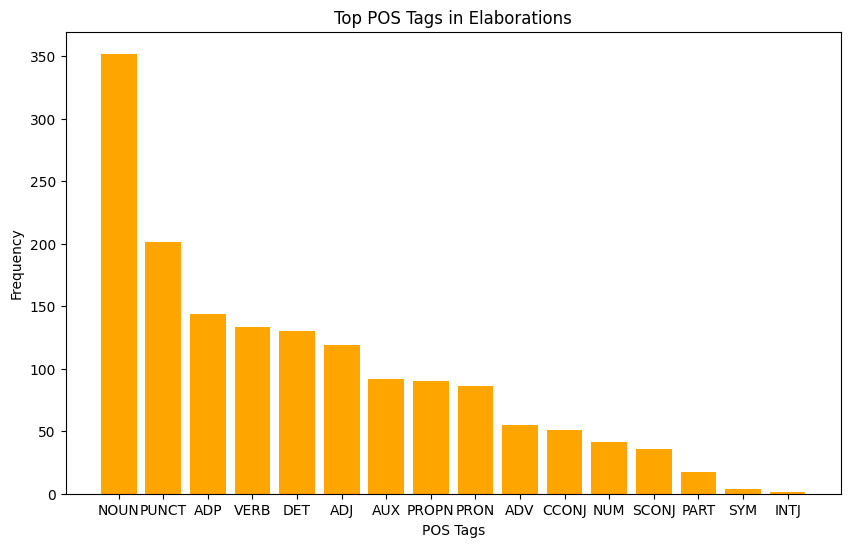

In [145]:
# analyze and plot the most frequent POS tags in elaborations
pos_frequencies = analyze_elaboration_pos(insertions)

In [146]:
print(pos_frequencies)

Counter({'NOUN': 352, 'PUNCT': 201, 'ADP': 144, 'VERB': 133, 'DET': 130, 'ADJ': 119, 'AUX': 92, 'PROPN': 90, 'PRON': 86, 'ADV': 55, 'CCONJ': 51, 'NUM': 41, 'SCONJ': 36, 'PART': 17, 'SYM': 4, 'INTJ': 1})
